





First step when we have to deal with a problem, is understand its nature.
So in this part, we spent some time trying to deeper understand features in x-ray images that imply the ifection of pneumonia.
Being ignorant of the detailed anatomy of chest cavity, it seemed useful to visualize all the body parts located there:

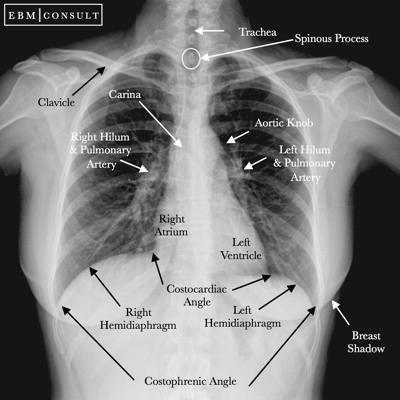

In general, pneumonia is an infection that causes inflammation in one or both of the lungs. It can be caused by a virus, bacteria, fungi or other germs. The infection is usually acquired when a person breathes in air carrying germs.


So which could be some possible features that identify a pneumonia infection?
Let's take a look at both a normal lung and a lung of a patient that has pneumonia.


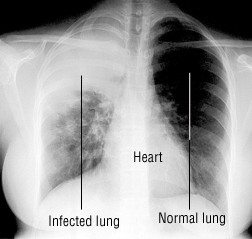

Fisrt thing we might notice in the case of pneumonia are some white spots resembling shadows, called infiltrates. In addition to this, what is also common is the loss of information compared to the normal condition. This means that in the X-ray of a patient that has pneumonia usually the borders of heart, diaphragm or the costophrenic angles are lost in comparison with the normal condition where the aforementioned parts are clearly visible and sharp. Also, in the Xray depicting pneumonia, we might notice some abscesses or pleural effusions which are fluid surroundings to the lungs.

The dataset provided by kaggle site has mainly two classes: the normal and the pneumonia which are saved in "NORMAL" and "PNEUMONIA" file correspondingly for each set. However, the pneumonia class could be further devided into the subclasses of viral and bacterial pneumonia.

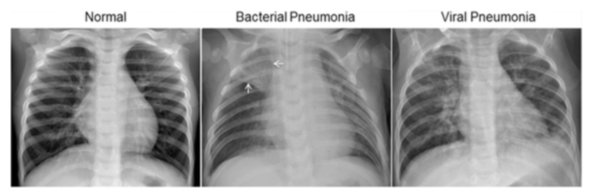

For the classification task of this project we define the initial two classes of normal and pneumonia. After taking a look at the viral and bacterial pneumonia pictures we conclude that it's much harder to distinguish between these two conditions than in the case of normal and pneumonia. In addition, the dataset is imbalanced containing more pneumonia xray images than normal, almost 3:1 analogy. Therefore, a possible approach for this problem could be to firstly train a model to classify normal and pneumonia conditions and next to train it to classify viral and bacteria pneumonia.





---



In [ ]:
import os
import glob
from google.colab import drive

drive.mount('/content/drive')

import numpy as np
import pandas as pd
import random
import itertools
import shutil
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.callbacks as c
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.random import set_seed
set_seed(42)

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
# move random files from one directory to another directory
def move_files_random(from_dir, to_dir, n):
    for filename in random.sample(os.listdir(from_dir), k=n):
        from_fpath = os.path.join(from_dir, filename)
        to_fpath = os.path.join(to_dir, filename)
        shutil.move(from_fpath, to_fpath)
    display(f"move {n} files from {from_dir} to {to_dir}")

# count how many normal-pneumonia-total images a folder containsyear = [2014, 2015, 2016, 2017, 2018, 2019]
def nb_samples(path):
  nb_normal    = len(os.listdir(os.path.join(path, 'NORMAL')))
  nb_pneumonia = len(os.listdir(os.path.join(path, 'PNEUMONIA')))
  nb_total     = nb_normal + nb_pneumonia
  nb_samples_l = [nb_normal, nb_pneumonia, nb_total]
  return nb_samples_l

def plot_sample_distributions(nb_train, nb_val, nb_test):

  sets = ["Train", "Validation", "Test"]
  normal = [nb_train[0],nb_val[0], nb_test[0]]
  pneumonia = [nb_train[1],nb_val[1], nb_test[1]]

  b1 = plt.barh(sets, normal, color="green")
  b2 = plt.barh(sets, pneumonia, left=normal, color="red")

  plt.legend([b1, b2], ["Normal", "Pneumonia"])
  plt.show()

#plot histogram of pixel intensities
def plotHistogram(a, title):

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a[:,:,0], cmap = 'gray')
    plt.title(title)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.hist(a.ravel(), bins=40, range=[0, 256], color='crimson')
    plt.title("Histogram Showing Pixel Intensities And Counts", color='crimson')
    plt.ylabel("Number Of Pixels Belonging To The Pixel Intensity", color="crimson")
    plt.xlabel("Pixel Intensity", color="crimson")
    plt.show()


# Convert image to normalized floating point
def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

def normalize(x):
  x_n = x.astype("float64")
  for i in range(x_n.shape[0]):
    x_n[i, :, :, 0] = im2double(x_n[i, :, :, 0])
  return x_n

def histogramEqualization(x):
  x_e = x.astype(np.uint8)
  for i in range(x_e.shape[0]):
    x_e[i, :, :, 0] = cv2.equalizeHist(x_e[i, :, :, 0])
  return x_e

def medianBlur(x, a):
  x_b = x.astype(np.uint8)
  for i in range(x_b.shape[0]):
    x_b[i, :, :, 0] = cv2.medianBlur(x_b[i, :, :, 0], a)
  return x_b

# helper function for transforming labels
def transform_1d_labels(labels):
    y_transformed_labels = np.zeros(labels.shape[0])
    for i in range(labels.shape[0]):
        y_transformed_labels[i] = int(np.argmax(labels[i]))
    return y_transformed_labels


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_cm_cl_report_ml(y_test, predictions):
  target_names = ["Normal", "Pneumonia"]
  print('Classification Report')
  print(classification_report(y_test, predictions, target_names=target_names))
  print('Confusion Matrix')
  cm = confusion_matrix(y_test, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

def print_cm_cl_report(test_generator, predictions):
  target_names = ["Normal", "Pneumonia"]
  print('Classification Report')
  print(classification_report(test_generator.classes, predictions, target_names=target_names))
  print('Confusion Matrix')
  cm = confusion_matrix(test_generator.classes, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

def print_loss_acc(history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax = ax.ravel()
  for i, metric in enumerate(['accuracy', 'loss']):
      ax[i].plot(history.history[metric])
      ax[i].plot(history.history['val_' + metric])
      ax[i].set_title('Model {}'.format(metric))
      ax[i].set_xlabel('epochs')
      ax[i].set_ylabel(metric)
      ax[i].legend(['Train', 'Validation'])

In [ ]:
dataset_path_L = '/content/drive/MyDrive/'

main_path = os.path.join(dataset_path_L,"Image_Processing_Final_Project/chest_xray")

train_path = os.path.join(main_path,"train")
val_path   = os.path.join(main_path,"val")
test_path  = os.path.join(main_path,"test")



---

**Data exploration**

First thing we'll do to explore the data is to print some examples of normal and pneumonia classes. As it has been previously mentioned, in some cases it is hard to distinguish between these two conditions if you don't have the sufficient knowledge in medicine, especially in the cases of viral and bacterial pneumonia. Overall we might say that the images that show the pneumonia infection appear to have less clear edges and more shadows.

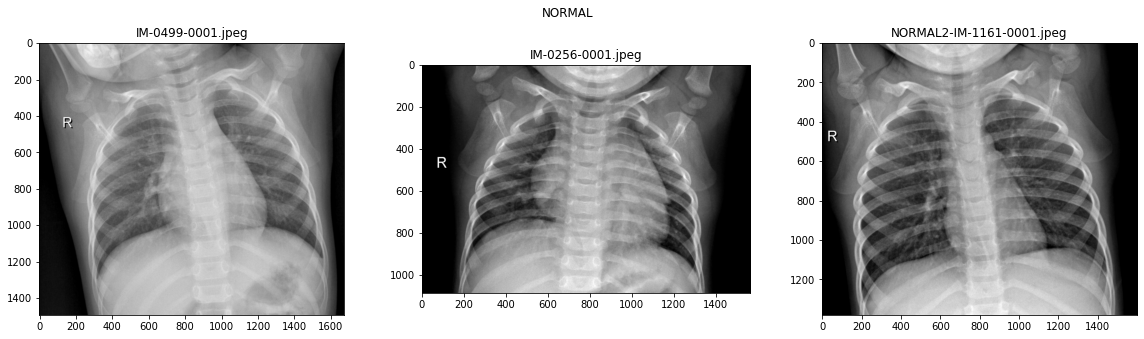

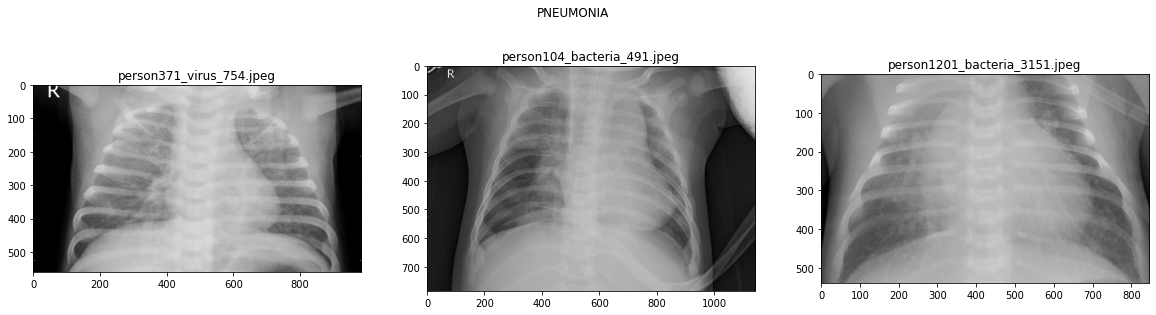

In [ ]:
img_normal = []
img_pneumonia = []
test_img_dir = test_path
train_img_dir = train_path
val_img_dir = val_path

for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
    for dirname, _, filenames in os.walk(os.path.join(img_dir, 'NORMAL')):
        for filename in filenames:
            img_normal.append(os.path.join(dirname, filename))
    for dirname, _, filenames in os.walk(os.path.join(img_dir, 'PNEUMONIA')):
        for filename in filenames:
            img_pneumonia.append(os.path.join(dirname, filename))

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax = ax.flatten()
plt.suptitle("NORMAL")
for i, j in enumerate(np.random.randint(len(img_normal), size=3).tolist()):
    ax[i].imshow(load_img(img_normal[j]))
    ax[i].set_title(img_normal[j].split('/')[-1]);

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax = ax.flatten()
plt.suptitle("PNEUMONIA")
for i, j in enumerate(np.random.randint(len(img_pneumonia), size=3).tolist()):
    ax[i].imshow(load_img(img_pneumonia[j]))
    ax[i].set_title(img_pneumonia[j].split('/')[-1]);

It is also interesting to print a histogram of the pixel intesity of each class so as to notice if there are any patterns.

Found 2776 files belonging to 2 classes.


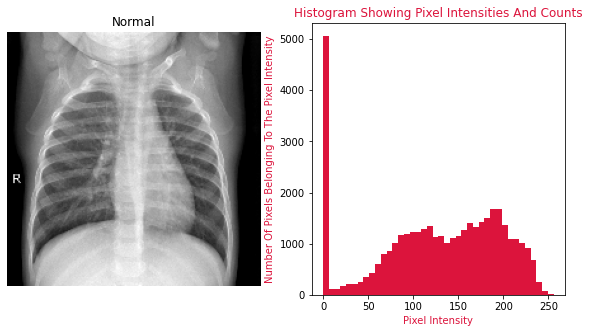

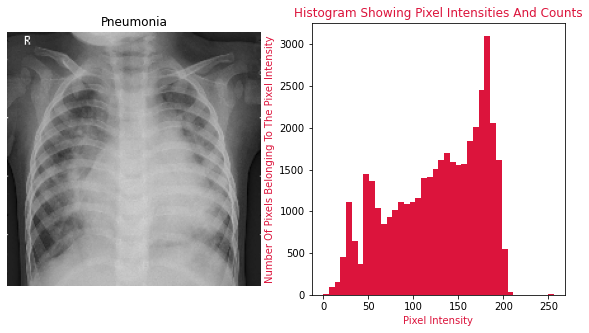

In [ ]:
train_dataset = image_dataset_from_directory(train_path,
                                             color_mode='grayscale',
                                             image_size=(200, 200),
                                             label_mode='categorical',
                                             batch_size=100
                                             )
x_train_ex, y_train_ex = train_dataset.as_numpy_iterator().next()
y_train_ex = transform_1d_labels(y_train_ex)

i = {} # list of indices, one for each class
for j in range(len(y_train_ex)):
  if len(i)>1:
    break
  if y_train_ex[j]==0:
    i['Normal'] = j
  elif y_train_ex[j]==1:
    i['Pneumonia'] = j

plotHistogram(x_train_ex[i['Normal']],'Normal')
plotHistogram(x_train_ex[i['Pneumonia']],'Pneumonia')

We could say that the histogram for normal cases is more wide, while the one showing pneumonia has a peak in the area of bright tones. The small peak in black tones is because of the black background.

Next step is to find out the distribution of samples among the train, validation and test sets. We notice that the validation set is too small and may cause oscilation in the training process. For this purpose, we move the 10% of samples of train set to validation set.


In [ ]:
nb_train = nb_samples(train_path)
nb_val   = nb_samples(val_path)
nb_test  = nb_samples(test_path)

nb_total_samples = nb_train[2] + nb_val[2] + nb_test[2]
classes = ["Normal", "Pneumonia", "Total"]

print("Train set consists of :" )
for j in range(3):
  print( classes[j], " : ", nb_train[j])
print("Validation set consists of :" )
for j in range(3):
  print(classes[j], " : ", nb_val[j])
print("Test set consists of :" )
for j in range(3):
  print(classes[j], " : ", nb_test[j])

Train set consists of :
Normal  :  1342
Pneumonia  :  3879
Total  :  5221
Validation set consists of :
Normal  :  8
Pneumonia  :  8
Total  :  16
Test set consists of :
Normal  :  234
Pneumonia  :  390
Total  :  624


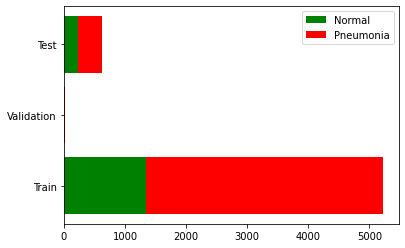

In [ ]:
plot_sample_distributions(nb_samples(train_path), nb_samples(val_path),nb_samples(test_path))

It's obvious that validation set is way to small in comparison with test and train set. Also, the dataset contains more pneumonia samples than normal. Well that could sound logical because it's rare someone to go for xray diagnosis if he has no symptoms.

In this step we move the 10% of training set to validation set.

In [ ]:
n_to_move = round(0.1*nb_train[2])
# count each n and p samples to move
# later train val have the same N/P proportion
n_to_move_N = round((nb_train[0] + nb_val[0]) /
                    (nb_train[2] + nb_val[2]) * n_to_move)

n_to_move_P = n_to_move - n_to_move_N

print(n_to_move)
print(n_to_move_N)
print(n_to_move_P)

522
135
387


Move files from training set to validation set.

In [ ]:
move_files_random(from_dir=os.path.join(train_path, 'NORMAL'),
                  to_dir=os.path.join(val_path, 'NORMAL'),
                  n=n_to_move_N)

move_files_random(from_dir=os.path.join(train_path, 'PNEUMONIA'),
                  to_dir=os.path.join(val_path, 'PNEUMONIA'),
                  n=n_to_move_P)

'move 135 files from /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/train/NORMAL to /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/val/NORMAL'

'move 387 files from /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/train/PNEUMONIA to /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/val/PNEUMONIA'

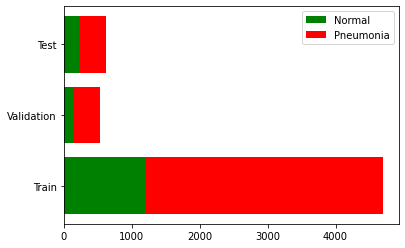

In [ ]:
plot_sample_distributions(nb_samples(train_path), nb_samples(val_path),nb_samples(test_path))

In [ ]:
nb_train = nb_samples(train_path)
nb_val   = nb_samples(val_path)
nb_test  = nb_samples(test_path)

nb_total_samples = nb_train[2] + nb_val[2] + nb_test[2]
classes = ["Normal", "Pneumonia", "Total"]

print("Train set consists of :" )
for j in range(3):
  print( classes[j], " : ", nb_train[j])
print("Validation set consists of :" )
for j in range(3):
  print(classes[j], " : ", nb_val[j])
print("Test set consists of :" )
for j in range(3):
  print(classes[j], " : ", nb_test[j])

Train set consists of :
Normal  :  1206
Pneumonia  :  3488
Total  :  4694
Validation set consists of :
Normal  :  143
Pneumonia  :  395
Total  :  538
Test set consists of :
Normal  :  234
Pneumonia  :  390
Total  :  624


Next, we can see that the dataset is imbalanced because there are much greater in number pneumonia samples than normal. For this reason we try all sets to get a more balanced proportion of normal and pneumonia samples by removing some of the pneumonia samples. We are not strict to the point that both classes have exactly the same number of samples, we just need them to be close enough because pneumonia images have more challenging patterns for the model to identify.

In [ ]:
n_remove_p_train = round(0.55*nb_train[1])
n_remove_p_val   = round(0.5*nb_val[1])
n_remove_p_test  = round(0.3*nb_test[1])

In [ ]:
move_files_random(from_dir=os.path.join(train_path, 'PNEUMONIA'),
                  to_dir=os.path.join(main_path, 'PNEUMONIA_EXTRA_TRAIN'),
                  n=n_remove_p_train)

move_files_random(from_dir=os.path.join(val_path, 'PNEUMONIA'),
                  to_dir=os.path.join(main_path, 'PNEUMONIA_EXTRA_VAL'),
                  n=n_remove_p_val)

move_files_random(from_dir=os.path.join(test_path, 'PNEUMONIA'),
                  to_dir=os.path.join(main_path, 'PNEUMONIA_EXTRA_TEST'),
                  n=n_remove_p_test)

'move 1918 files from /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/train/PNEUMONIA to /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/PNEUMONIA_EXTRA_TRAIN'

'move 198 files from /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/val/PNEUMONIA to /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/PNEUMONIA_EXTRA_VAL'

'move 117 files from /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/test/PNEUMONIA to /content/drive/MyDrive/Image_Processing_Final_Project/chest_xray/PNEUMONIA_EXTRA_TEST'

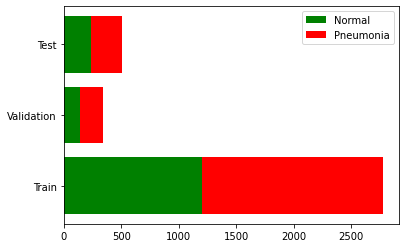

In [ ]:
plot_sample_distributions(nb_samples(train_path), nb_samples(val_path),nb_samples(test_path))

In [ ]:
nb_train = nb_samples(train_path)
nb_val   = nb_samples(val_path)
nb_test  = nb_samples(test_path)

nb_total_samples = nb_train[2] + nb_val[2] + nb_test[2]
classes = ["Normal", "Pneumonia", "Total"]

print("Train set consists of :" )
for j in range(3):
  print( classes[j], " : ", nb_train[j])
print("Validation set consists of :" )
for j in range(3):
  print(classes[j], " : ", nb_val[j])
print("Test set consists of :" )
for j in range(3):
  print(classes[j], " : ", nb_test[j])

Train set consists of :
Normal  :  1206
Pneumonia  :  1570
Total  :  2776
Validation set consists of :
Normal  :  143
Pneumonia  :  197
Total  :  340
Test set consists of :
Normal  :  234
Pneumonia  :  273
Total  :  507


In [ ]:
nb_train_samples = nb_train[2]
nb_val_samples   = nb_val[2]
nb_test_samples  = nb_test[2]

More balanced distribution of samples over trainig, validation and test sets.



---



# Machine Learning

Firstly we load all datasets using image_dataset_from_directory in grayscale form and 200 x 200 size. We add a big batch size to include all images in each directory. The label_mode is set to categorical since we have 2 classes for classification.

In [ ]:
train_dataset = image_dataset_from_directory(train_path,
                                             color_mode='grayscale',
                                             image_size=(200, 200),
                                             label_mode='categorical',
                                             batch_size=10000
                                             )

val_dataset = image_dataset_from_directory(val_path,
                                           color_mode='grayscale',
                                           image_size=(200, 200),
                                           label_mode='categorical',
                                           batch_size=1000
                                           )

test_dataset = image_dataset_from_directory(test_path,
                                            color_mode='grayscale',
                                            image_size=(200, 200),
                                            label_mode='categorical',
                                            batch_size=1000
                                            )

Found 2776 files belonging to 2 classes.
Found 340 files belonging to 2 classes.
Found 507 files belonging to 2 classes.


Next step is to convert the data from the tf.data.Dataset form from previous step into numpy arrays. Additionally we convert the labels to 1d array in order to be processed correctly by the following classification models.

In [ ]:
x_train, y_train = train_dataset.as_numpy_iterator().next()
x_val, y_val = val_dataset.as_numpy_iterator().next()
x_test, y_test = test_dataset.as_numpy_iterator().next()

y_train = transform_1d_labels(y_train)
y_val = transform_1d_labels(y_val)
y_test = transform_1d_labels(y_test)

One important step that improves the effeciency of classification models is the normalization of the data.

In [ ]:
x_train_n = normalize(x_train)
x_val_n   = normalize(x_val)
x_test_n  = normalize(x_test)

In [ ]:
nsamples_train, nx_train, ny_train, _ = x_train.shape
nsamples_test, nx_test, ny_test, _ = x_test.shape

x_train_r = x_train.reshape(nsamples_train,nx_train*ny_train)
x_test_r = x_test.reshape(nsamples_test,nx_test*ny_test)

Usually before applying a ML model its useful to run a baseline model. For this task we applied Gaussian Naive Bayes beacause it's probabilistic machine learning model based on Bayes theorem and has not hyperparameters that need tuning. So after we make a first estimation of the problem and evaluate Gaussian Naive Bayes model we will proceed to SVM.

Cross-validation is mainly used as a way to check for over-fit and if the model generalizes well across different test sets. So for this task, cross-validation builds k estimators (k-fold CV) and then we're able to check the predictive efficiency of the model on the data by comparing the mean and std of the quality measure. A high mean and low standard deviation of the quality measure would mean the model generalizes well.



In [ ]:
g_nb = GaussianNB()
cv = StratifiedKFold(n_splits=5,random_state = 8,shuffle=True) # Creating a StratifiedKFold object with 5 folds
cv_scores = cross_val_score(g_nb, x_train_r, y_train,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold

g_nb.fit( x_train_r, y_train) # Fitting the model

train_score = g_nb.score(x_train_r, y_train) # Scoring the model on train set
print("Score (accuracy) on train set {:.4f}".format(train_score))
print("Average score (accuracy) in training {:.4f}".format(np.mean(cv_scores)))
print("Std of score (accuracy) in training {:.4f}".format(np.std(cv_scores)))

Score (accuracy) on train set 0.8646
Average score (accuracy) in training 0.8610
Std of score (accuracy) in training 0.0210




To evaluate each proposed model on the classification task we are using  confusion matrix, in which the number of correct and incorrect predictions are summarized with count values and broken down by each class. So basically the confusion matrix comprises:

*   True Positives (TP), in which case we predicted positive, and they are actually in positive class.
*   False Positive (FP or Type 1 Error), in which case we predicted postive, but they are actually negative.
*   True Negative (TN), in which case we predicted negative, and they are actually negative.
*   False Negative (FN or Type 2 Error), in which case we predicted negative, but they are actually postive.

Considering that positive class in our case study refers to "normal" - healthy patients- and negative class to "pneumonia", the goal except for maximising the diagonal elements (TF, TN) could be also focused on minimising the FN. This means that it's more crucial to eliminate the cases when people with pneumonia are predicted as healthy, because they will loose the chance to take the suggested remedy on time and recover.


Additionally we print the accuracy score and the classification report, which contains the precision, recall and f1-score metrics.



*  Accuracy, shows the fraction of predictions the model got right : (TP+TN) / (TP+FP+FN+TN)

*   Recall, shows what proportion of actual positives was identified correctly : TP / (TP+FN)
*   Precision, shows the proportion of positive identifications was actually correct : TP / (TP+FP)
*   F1 - Score, can be interpreted as a harmonic mean of the precision and recall: 2 (precision recall) / (precision + recall)

Following the previous approach we could say that the maximization of accuracy and recall are more relevant.


Gaussian_NB accuracy score :  0.7120315581854043
Classification Report
              precision    recall  f1-score   support

      Normal       0.72      0.62      0.67       234
   Pneumonia       0.71      0.79      0.75       273

    accuracy                           0.71       507
   macro avg       0.71      0.71      0.71       507
weighted avg       0.71      0.71      0.71       507

Confusion Matrix


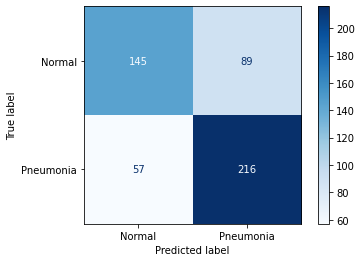

In [ ]:
y_pred = g_nb.predict(x_test_r)
print("Gaussian_NB accuracy score : ", accuracy_score(y_test,y_pred))
print_cm_cl_report_ml(y_test, y_pred)

We can conclude that Gaussian Naive Bayes had a satisfible performance as a model achieving 71.2% accuracy. Both recall which is of first importance and precision are a bit low meaning there are many FP and FN. Taking into account the results of the baseline model we will try to see if a more complex ML model will outperfom it and actually minimize the cases where people would be wrongly diagnosed with pneumonia.



# SVM

Before running the SVM model for classification we implement Principal Component Analysis (PCA), which is a linear dimensionality reduction using singular value decomposition of the data to project it to a lower dimensional space. The dimensionality reduction will positively contribute to the time complexity when training the SVM model. We choose to keep features that explain the most variance in our data, specifically 95% of variance.

The Support Vector Machine model is capable of handling more efficiently non linear input spaces compared to other machine learning models due to the use of kernels. Overall as a model constructs a decision plane (for example hyperplane) in multidimensional space to separate different classes. Then generates optimal hyperplane in an iterative manner, which is used to minimize an error. As support vectors are defined the data points, which are closest to the hyperplane and the distance between the either nearest points is known as the margin. The main objective of SVM is to find a maximum marginal hyperplane(MMH) that best divides the dataset into classes.

The tuning hyperparameters of SVM algorithm that we are going to experiment using GridsearchCV package are :

- Regularization parameter C: serves as a penalty parameter, which represents misclassification or error term, which indicates to the SVM optimization how much error is tolerable. In other words, helps to control the trade-off between decision boundary and misclassification term. A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.
- Gamma: a low value of gamma considers only nearby points in calculating the decision plane, while a higher value of gamma considers all the data points in the calculation of the separation line leading to overfitting.

- Kernel: transforms the input trainig data into the required form based on various types of functions such as linear, polynomial, and radial basis function (RBF). Polynomial and RBF kernels compute the separation line in the higher dimension. In our case we will try all 3 aforementioned kernels.



To perform hyperparameter tuning of the SVM model and determine the optimal values we use GridSearchCV. To save some time we apply GridSearchCV on validation set which is comparatively smaller and set cross-validation parameter equal to 5 for each set of hyperparameters in order to avoid overfitting.

In [ ]:
pca = PCA(n_components=0.95, whiten = True, random_state=42)
svc =SVC(class_weight = 'balanced')
model = make_pipeline(pca, svc)

In [ ]:
x_train_r = x_train_n.reshape(x_train_n.shape[0],x_train_n.shape[1]*x_train_n.shape[2])
x_val_r = x_val_n.reshape(x_val_n.shape[0],x_val_n.shape[1]*x_val_n.shape[2])
x_test_r = x_test_n.reshape(x_test_n.shape[0],x_test_n.shape[1]*x_test_n.shape[2])

Best parameters: {'svc__C': 0.01, 'svc__gamma': 1, 'svc__kernel': 'linear'}
SVM accuracy score on test set: 0.7179
Classification Report
              precision    recall  f1-score   support

      Normal       0.93      0.42      0.58       234
   Pneumonia       0.66      0.97      0.79       273

    accuracy                           0.72       507
   macro avg       0.80      0.70      0.68       507
weighted avg       0.79      0.72      0.69       507

Confusion Matrix


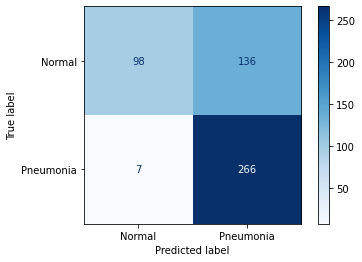

In [ ]:
param_grid ={'svc__C':[0.01, 0.1, 1],'svc__gamma':[1, 0.1, 0.01], 'svc__kernel':['linear','polynomial']}
grid = GridSearchCV(model, param_grid)

grid.fit(x_train_r,y_train)
print(f"Best parameters: {grid.best_params_}")

model = grid.best_estimator_
pred_svm = model.predict(x_test_r)

print("SVM accuracy score on test set: {:.4f}".format(accuracy_score(y_test,pred_svm)))
print_cm_cl_report_ml(y_test, pred_svm)


We notice that overall accuracy score 71.79% is close to previous model 71.20%, it has just a little bit increased. On the one hand the predicted FN are comparably lower including only 7 cases, which is very important. Additionaly, more pneumonia cases were correctly predicted, the TN elements of confusion matrix. On the other hand, the class of normal perfomed worse. Less TP were predicted correctly and many more FP were counted. The second case is not as dangerous as the case of FN because those people are actually healthy, but putting stress on them because of mistaken diagnosis is something undesirable. For this reason in next step we experiment a little bit more in preprocessing phase so as to check if the same model will perform better.

# SVM - adding preprocessing steps



First thing we will try in preprocessing phase is removing some of the noise by using median blur like what we've already done in previous assignments.

In [ ]:
x_train_b = medianBlur(x_train,7)
x_val_b   = medianBlur(x_val, 7)
x_test_b  = medianBlur(x_test, 7)

It's interesting to observe how the images are transformed and what changes are made to their intensity histograms, so we display both of them.

Before applying Median Blur


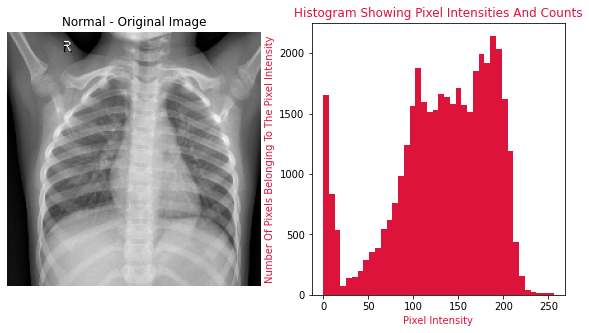

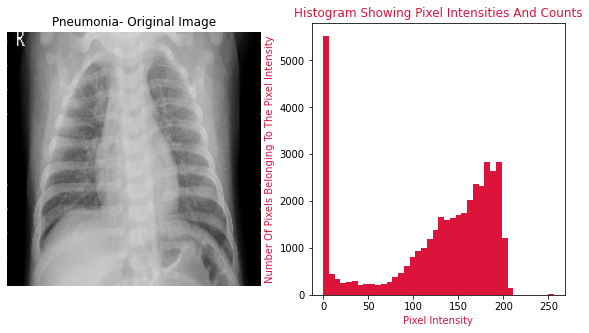

After applying Median Blur


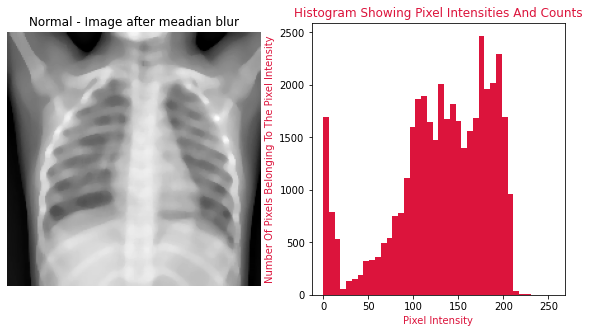

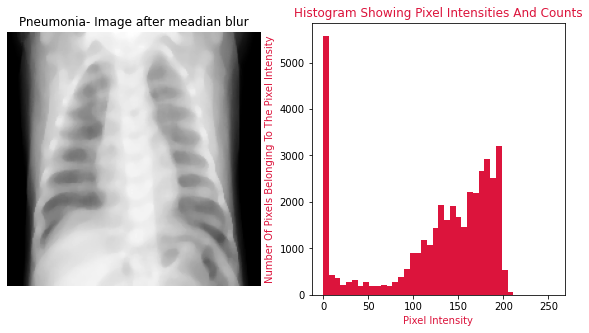

In [ ]:
i = {} # list of indices, one for each class
for j in range(len(y_train)):
  if len(i)>1:
    break
  if y_train[j]==0:
    i['Normal'] = j
  elif y_train[j]==1:
    i['Pneumonia'] = j

print('Before applying Median Blur')
plotHistogram(x_train[i['Normal']],'Normal - Original Image')
plotHistogram(x_train[i['Pneumonia']],'Pneumonia- Original Image')

print('After applying Median Blur')
plotHistogram(x_train_b[i['Normal']],'Normal - Image after meadian blur')
plotHistogram(x_train_b[i['Pneumonia']],'Pneumonia- Image after meadian blur')

It seems like not much noise has been removed, but we will find out in the results if it was sufficient to improve model's performance.

Additionally we apply histogram equalization and display the images to see if this transformation could be helpful too.

In [ ]:
x_train_be = histogramEqualization(x_train_b)
x_val_be   = histogramEqualization(x_val_b)
x_test_be  = histogramEqualization(x_test_b)

Before applying Median Blur and Histogram Equalization


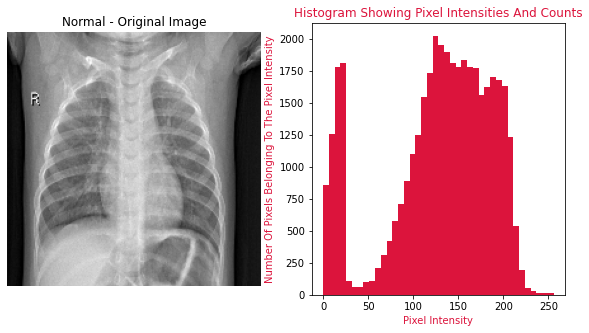

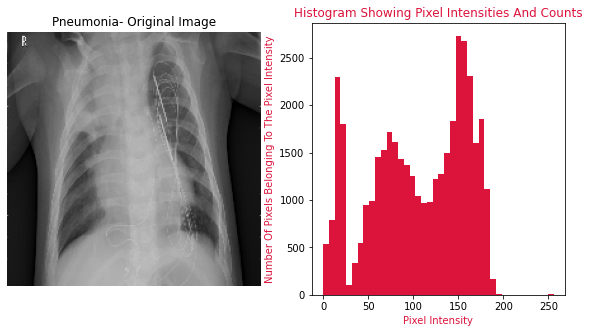

After applying Median Blur and Histogram Equalization


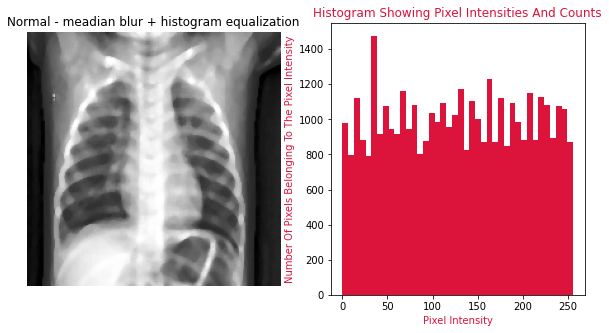

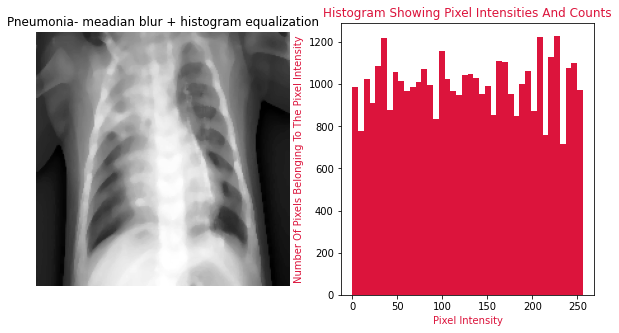

In [ ]:
i = {} # list of indices, one for each class
for j in range(len(y_train)):
  if len(i)>1:
    break
  if y_train[j]==0:
    i['Normal'] = j
  elif y_train[j]==1:
    i['Pneumonia'] = j

print('Before applying Median Blur and Histogram Equalization')
plotHistogram(x_train[i['Normal']],'Normal - Original Image')
plotHistogram(x_train[i['Pneumonia']],'Pneumonia- Original Image')

print('After applying Median Blur and Histogram Equalization')
plotHistogram(x_train_be[i['Normal']],'Normal - meadian blur + histogram equalization')
plotHistogram(x_train_be[i['Pneumonia']],'Pneumonia- meadian blur + histogram equalization')

We notice that after applying the histogram equalization the intensity histogramms of the images appear to have less divergence which may not help the model in classification task. For this reason we proceed only with median blur.

In [ ]:
x_train_b_n = normalize(x_train_b)
x_val_b_n   = normalize(x_val_b)
x_test_b_n  = normalize(x_test_b)

In [ ]:
x_train_r_bn = x_train_b_n.reshape(x_train_b_n.shape[0],x_train_b_n.shape[1]*x_train_b_n.shape[2])
x_val_r_bn = x_val_b_n.reshape(x_val_b_n.shape[0],x_val_b_n.shape[1]*x_val_b_n.shape[2])
x_test_r_bn = x_test_b_n.reshape(x_test_b_n.shape[0],x_test_b_n.shape[1]*x_test_b_n.shape[2])

SVM accuracy score on test set: 0.7318
Classification Report
              precision    recall  f1-score   support

      Normal       0.94      0.45      0.61       234
   Pneumonia       0.67      0.97      0.80       273

    accuracy                           0.73       507
   macro avg       0.81      0.71      0.70       507
weighted avg       0.80      0.73      0.71       507

Confusion Matrix


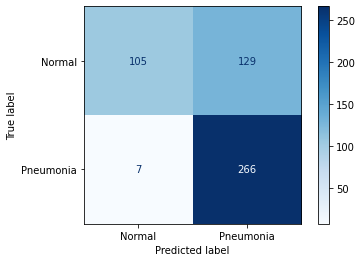

In [ ]:
pca = PCA(n_components=0.95, whiten = True, random_state=42)
svc =SVC(class_weight = 'balanced', C = 0.01, gamma = 1, kernel='linear')
model2 = make_pipeline(pca, svc)

model2.fit(x_train_r_bn,y_train)
pred_svm2 = model2.predict(x_test_r_bn)

print("SVM accuracy score on test set: {:.4f}".format(accuracy_score(y_test,pred_svm2)))
print_cm_cl_report_ml(y_test, pred_svm2)

Well, all we got comparing to previous SVM model is 5 less stressed people! This means that the sum of TP incresed by 5. The other predictions for pneumonia class remained the same. These results prove that experimenting with preprocessing can increase model's efficiency. In this stage, it would be helpful to have a deeper understanding of the medical problem in order to understand which features need to be detected and then to implement a more focused preprocessing. Otherwise, random preprocessing techniques may lead to better results but it will be more challenging to understand the real reason behind this.



---



# Neural Networks



---



We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each set using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [ ]:
IMG_SIZE   = (200, 200)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=15,  # degrees
                   zoom_range=0.2,
                   width_shift_range=0.08,  # per cent width
                   height_shift_range=0.08,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_path,
                                   target_size = IMG_SIZE,
                                   batch_size  = BATCH_SIZE,
                                   class_mode='binary',
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow_from_directory(
                                val_path,
                                target_size= IMG_SIZE,
                                batch_size = BATCH_SIZE,
                                class_mode='binary',
                                )

test_generator = test_datagen.flow_from_directory(
                                test_path,
                                target_size = IMG_SIZE,
                                batch_size = BATCH_SIZE,
                                shuffle=False,
                                class_mode='binary',
                                )

Found 2776 images belonging to 2 classes.
Found 340 images belonging to 2 classes.
Found 507 images belonging to 2 classes.




---



# CNN model

Next step is to build the CNN model employing TensorFlow Functional API. So we start by creating an input node and adding the shape and dtype of the input images that are given to the model.
The layers that constitute the architecture of the CNN model are the following:

- Conv2D(): 2D convolution over the image, helps for feature extraction
- MaxPool2D(): helps to down sample the detection of features in feature map by keeping the most activated presence of a feature (maximum)
- Flatten(): used to flatten the input into single dimension.
- Dense(): add densely connected layer
- Dropout() : helps to avoid over-fitting by neglecting randomly selected neurons throughout training.





---



# Baseline CNN

The architecture of the baseline CΝN consists of three convolutional layers, followed by a nonlinear ReLU activation layer and maximum pooling layer.This part of the model is used for the feature extraction. On top of it is used a flatten layer which is followed by two fully connected (FC) layers and Dropout layers, followed by an FC softmax layer.The softmax activation function is applied for the image classification task of normal and pneumonia classes.

The Adam was used as optimizer and cross-entropy as loss function which is suggested when the output layer models distributions (Softmax activation function).


In [ ]:
IMG_WIDTH, IMG_HEIGHT = 200,200

inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))

# First conv layer
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv layer
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv layer
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# FC layer
x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model_b = Model(inputs=inputs, outputs=output)

# Summary of the model
model_b.summary()

# Configure the model for traning by adding metrics
model_b.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 64)        3692

Above we can take a look at the model summary and see the total number of trainable parameters close to 2M.

Next, we use fit_generator function to train the model giving as input the generator of training and validation set. Here the steps_per_epoch parameter refers to the number of batches of samples to yield from generator before declaring one epoch finished and starting the next epoch, so it is calculated as shown bellow. The same way is calculated the validation_steps for the validation set. In addition, EarlyStopping has been added in callbaks.
EarlyStopping helps us avoid overfitting by stopping the training process when the generalization gap increases over a defined threshold and doesn't decreases anymore. As generalization gap is mentioned the difference between training and validation error.

In [ ]:
EPOCHS = 20
BATCH_SIZE =  32
callback = c.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model_b.fit_generator(
                      train_generator,
                      steps_per_epoch = nb_train_samples//BATCH_SIZE+1,
                      epochs=EPOCHS,
                      validation_data = val_generator,
                      validation_steps = nb_val_samples//BATCH_SIZE+1,
                      callbacks = [callback]
                      )

Epoch 1/20
87/87 [==============================] - 73s 835ms/step - loss: 0.6033 - accuracy: 0.6740 - val_loss: 0.4811 - val_accuracy: 0.7618
Epoch 2/20
87/87 [==============================] - 71s 822ms/step - loss: 0.3875 - accuracy: 0.8422 - val_loss: 0.2738 - val_accuracy: 0.9059
Epoch 3/20
87/87 [==============================] - 72s 834ms/step - loss: 0.3172 - accuracy: 0.8736 - val_loss: 0.3771 - val_accuracy: 0.8029
Epoch 4/20
87/87 [==============================] - 72s 830ms/step - loss: 0.3116 - accuracy: 0.8775 - val_loss: 0.2331 - val_accuracy: 0.9147
Epoch 5/20
87/87 [==============================] - 73s 836ms/step - loss: 0.2941 - accuracy: 0.8916 - val_loss: 0.2492 - val_accuracy: 0.9029
Epoch 6/20
87/87 [==============================] - 71s 815ms/step - loss: 0.2743 - accuracy: 0.8909 - val_loss: 0.2294 - val_accuracy: 0.9088
Epoch 7/20
87/87 [==============================] - 71s 823ms/step - loss: 0.2376 - accuracy: 0.9031 - val_loss: 0.2233 - val_accuracy: 0.9206

In [ ]:
score = model_b.evaluate(test_generator,
                       steps=nb_test_samples//32+1)

16/16 [==============================] - 6s 370ms/step - loss: 0.2976 - accuracy: 0.9014


We display the model accuracy and loss for training and validation sets thoughout training process. We notice that in both cases the train and validation lines are close to each other, which is good because when there is great distance it's sign of over-fitting.

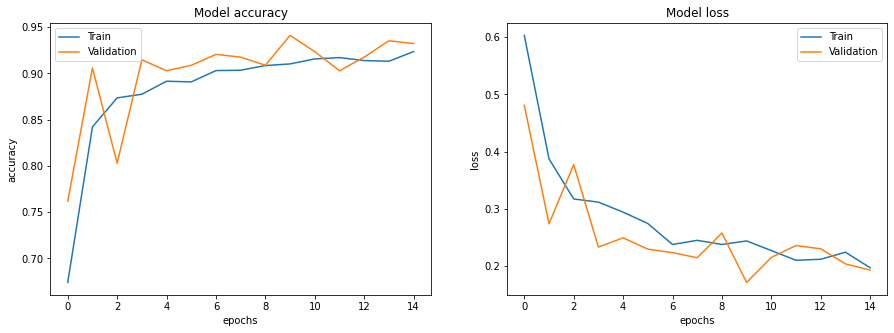

In [ ]:
print_loss_acc(history)

Here, we notice that the validation score is a bit higher than the training score. One possible reason could be that the validation set as it is randomly chosen happended to have easier samples for the model to predict, for example with less noise or variance. Another possible reason could be the use of Dropout, because when training a percentage of the neurons (features) are neglected while in testing, all features are used and as a result can end to higher testing accuracies.

Classification Report
              precision    recall  f1-score   support

      Normal       0.96      0.82      0.88       234
   Pneumonia       0.86      0.97      0.91       273

    accuracy                           0.90       507
   macro avg       0.91      0.90      0.90       507
weighted avg       0.91      0.90      0.90       507

Confusion Matrix


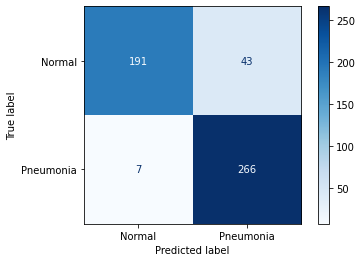

In [ ]:
predictions = model_b.predict_generator(test_generator, nb_test_samples // 32 +1)
predictions = [1 if x>0.5 else 0 for x in predictions]

print_cm_cl_report(test_generator, predictions)

Overall we notice that CNN performs better comparing to ML models. The total accuracy of the model is 90.14% while train accuracy results in 92.16% which is not a big difference.

However what makes the difference comparing to ML models, is that the FN are minimized. This means that even less people that actually have pneumonia were wrongly predicted as healthy. Of course there still are some missclassifications of type FP, people who are actually healthy but were wrongly diagnosed with pneumonia. This is not desirable, but it's still not as dangerous as the previous case. Also, it's possible that those people go again for a check up and hopefully get correctly diagnosed the second time.



---



# *2nd CNN model*

The architecture of the next CNN consists of five convolutional layers, followed by a nonlinear ReLU activation layer, a maximum pooling layer, and, finally, three fully connected (FC) layers, followed by an FC softmax layer, for the image classification task into normal and pneumonia classes.

Also, in between have been used dropouts to reduce over-fitting.

The activation function is set Relu for all layers except for the last layer where this time is set Sigmoid for the binary classification problem.
The Adam was used as optimizer and cross-entropy as loss function which is suggested when the output layer models probabilities (Sigmoid activation function). Early stopping is again added.

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 200,200
#draft model mine

inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))

# First conv block
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)

# to get the summary of the model
model.summary()

# configure the model for traning by adding metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 46, 46, 64)        1849

In [ ]:
EPOCHS = 40
BATCH_SIZE =  32
callback = c.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
history = model.fit_generator(
                      train_generator,
                      steps_per_epoch=nb_train_samples//BATCH_SIZE+1,
                      epochs=EPOCHS,
                      validation_data=val_generator,
                      validation_steps=nb_val_samples//BATCH_SIZE+1,
                      callbacks = [callback]
                      )


Epoch 1/40
87/87 [==============================] - 72s 832ms/step - loss: 0.1685 - accuracy: 0.9370 - val_loss: 0.1628 - val_accuracy: 0.9529
Epoch 2/40
87/87 [==============================] - 71s 811ms/step - loss: 0.1632 - accuracy: 0.9380 - val_loss: 0.1620 - val_accuracy: 0.9500
Epoch 3/40
87/87 [==============================] - 70s 803ms/step - loss: 0.1570 - accuracy: 0.9406 - val_loss: 0.1989 - val_accuracy: 0.9412
Epoch 4/40
87/87 [==============================] - 70s 811ms/step - loss: 0.1674 - accuracy: 0.9366 - val_loss: 0.1663 - val_accuracy: 0.9471
Epoch 5/40
87/87 [==============================] - 71s 822ms/step - loss: 0.1414 - accuracy: 0.9499 - val_loss: 0.1602 - val_accuracy: 0.9382
Epoch 6/40
87/87 [==============================] - 70s 799ms/step - loss: 0.1567 - accuracy: 0.9449 - val_loss: 0.1756 - val_accuracy: 0.9353
Epoch 7/40
87/87 [==============================] - 70s 800ms/step - loss: 0.1588 - accuracy: 0.9391 - val_loss: 0.1565 - val_accuracy: 0.9500

In [ ]:
score = model.evaluate(test_generator,
                       steps=nb_test_samples//32+1,
                       )

16/16 [==============================] - 6s 352ms/step - loss: 0.2768 - accuracy: 0.9132


Classification Report
              precision    recall  f1-score   support

      Normal       0.98      0.83      0.90       234
   Pneumonia       0.87      0.99      0.92       273

    accuracy                           0.91       507
   macro avg       0.93      0.91      0.91       507
weighted avg       0.92      0.91      0.91       507

Confusion Matrix


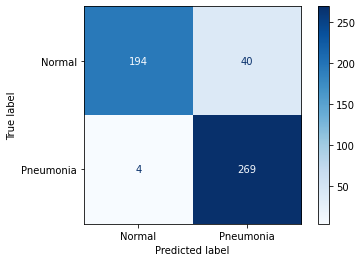

In [ ]:
predictions = model.predict_generator(test_generator, nb_test_samples // 32 +1)
predictions = [1 if x>0.5 else 0 for x in predictions]

print_cm_cl_report(test_generator, predictions)

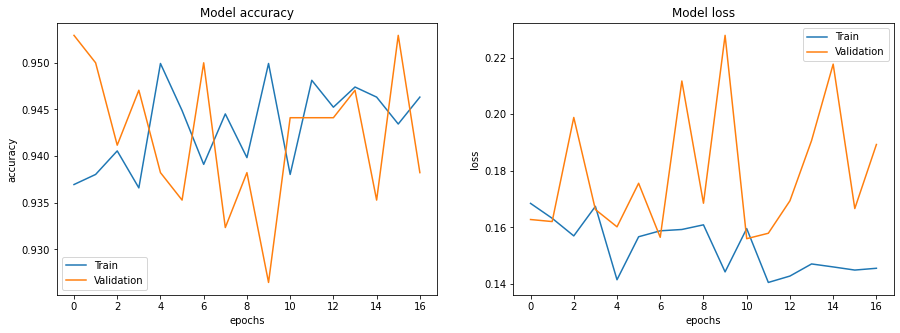

In [ ]:
print_loss_acc(history)

The second model performs a bit better than the previous one having overall 91.32% accuracy. The FN here are 4 while the FP are 40. Both are minimized. The difference may not be that big compared to the previous CNN, but it is important to focus on the application of each problem. When it's applied on people's health even 3 less people being wrongly diagnosed can make a difference.

In [ ]:
from keras.models import load_model

model.save('CNN_2nd_91_32.h5')  # creates a HDF5 file





---







# Transfer learning - VGG-16




Another approach we will try to experiment with are the pre-trained models. As pre-trained model we mean a model that has been previously trained on usually really large dataset(s) and contains the weights and biases that represent the features of the dataset(s) it was trained on. This can be beneficial in order to save time and compute resources needed to train such large datasets.

Hence, first model we will try is the pre-trained VGG-16 model for feature extraction.

VGG16 is a CNN model for Large-Scale Image Recognition, and is trained on ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

So, first we load the pre-trained model using Keras and download the required model weights. For this task we set the “include_top” argument to False so as the FC output layers of the VGG-16 model used to make predictions not to be loaded. We replace this part by adding a new densely connected layer with relu activation function, followed by a Dropout layer and then new output layer with sigmoid activation function. This part of the model which is responsible for the image classification will get trained.
It is specified that VGG-16 model takes as input images of fixed size (224,224) so we load again the data generators to reshape the images stored in the drive folders. In data generator of train set we also add other variables like rotation_range which will help in data augmentation process.


In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=8,  # degrees
                   zoom_range=0.1,
                   width_shift_range=0.08,  # per cent width
                   height_shift_range=0.08,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.02,
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_path,
                                   target_size = IMG_SIZE,
                                   batch_size  = BATCH_SIZE,
                                   class_mode='binary',
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow_from_directory(
                                val_path,
                                target_size= IMG_SIZE,
                                batch_size = BATCH_SIZE,
                                class_mode='binary',
                                )

test_generator = test_datagen.flow_from_directory(
                                test_path,
                                target_size = IMG_SIZE,
                                batch_size = BATCH_SIZE,
                                shuffle=False,
                                class_mode='binary',
                                )

Found 2776 images belonging to 2 classes.
Found 340 images belonging to 2 classes.
Found 507 images belonging to 2 classes.


In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224 , 224
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )
for i in base_model.layers:
    i.trainable=False


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
NUM_CLASSES = 1

x = base_model.output
x = keras.layers.GlobalMaxPooling2D()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(rate=0.25)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model_2 = Model(inputs=base_model.input, outputs=output)

# to get the summary of the model
model_2.summary()

# configure the model for traning by adding metrics
model_2.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-6), metrics = ['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
import tensorflow.keras.callbacks as c
epochs = 100
batch_size = 32
es = c.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history_2 = model_2.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs=epochs,
    validation_data = val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [es]
)

Epoch 1/100
86/86 [==============================] - 84s 956ms/step - loss: 0.9139 - accuracy: 0.4388 - val_loss: 0.8026 - val_accuracy: 0.4250
Epoch 2/100
86/86 [==============================] - 76s 885ms/step - loss: 0.8641 - accuracy: 0.4468 - val_loss: 0.7598 - val_accuracy: 0.4375
Epoch 3/100
86/86 [==============================] - 76s 884ms/step - loss: 0.8165 - accuracy: 0.4676 - val_loss: 0.7196 - val_accuracy: 0.4875
Epoch 4/100
86/86 [==============================] - 77s 896ms/step - loss: 0.7843 - accuracy: 0.4723 - val_loss: 0.6969 - val_accuracy: 0.5188
Epoch 5/100
86/86 [==============================] - 78s 910ms/step - loss: 0.7735 - accuracy: 0.4694 - val_loss: 0.6697 - val_accuracy: 0.5875
Epoch 6/100
86/86 [==============================] - 77s 895ms/step - loss: 0.7544 - accuracy: 0.4865 - val_loss: 0.6589 - val_accuracy: 0.6125
Epoch 7/100
86/86 [==============================] - 77s 894ms/step - loss: 0.7450 - accuracy: 0.5051 - val_loss: 0.6469 - val_accuracy:

In [ ]:
score = model_2.evaluate(test_generator,
                       steps= nb_test_samples//32+1)

16/16 [==============================] - 7s 418ms/step - loss: 0.4966 - accuracy: 0.7988


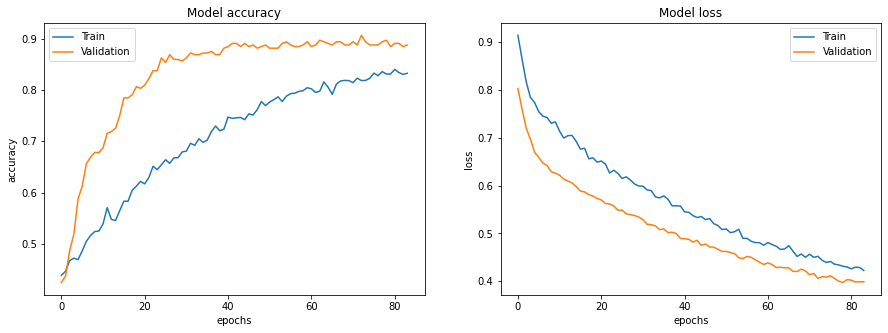

In [ ]:
print_loss_acc(history_2)

Classification Report
              precision    recall  f1-score   support

      Normal       0.81      0.74      0.77       234
   Pneumonia       0.79      0.85      0.82       273

    accuracy                           0.80       507
   macro avg       0.80      0.79      0.80       507
weighted avg       0.80      0.80      0.80       507

Confusion Matrix


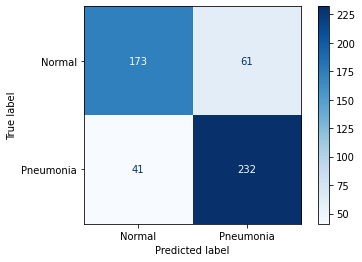

In [ ]:
predictions = model_2.predict_generator(test_generator, nb_test_samples// 32 +1)
predictions = [1 if x>0.5 else 0 for x in predictions]

print_cm_cl_report(test_generator, predictions)

As we can see the model using the pre-trained model VGG-16 for feature extraction achieved an overall accuracy 79.88%. It's lower than the previous two CNN models and FN are comparatively higher too, while recall score is lower.

Those results make us wonder how much of a good idea it was to use a pre-trained model like VGG-16 that is trained on natural images, most of them colored and belonging to classes like animals, cars, sports, food etc. There is a class in ImageNet named "medicine chest, medicine cabinet" but still the proportion compared to the rest of the dataset is very small. Well, research community seems to be a bit divided in this subject of using transfer learning for medical imaging applications.
Transfer learning could be beneficial when the training sample size is small, which is a common phenomenon for medical images.

Last, it's interesting to mention what has been concluded in the paper of Raghu, Maithra et.al, “*Transfusion: Understanding Transfer Learning for Medical Imaging*”.

When they tried initializing the non-standard networks with random weights (instead of weights of pretrained ImageNet models), which were derived by the mean and standard deviation of the random initialization based on pretrained weights, they found that it too provided the convergence speedup that pretrained models had.
This implies that ImageNet based models are characterized by overparametrization for the task of xray image classification. This is why it was also proved that non-standard models may outperform ImageNet models, which has been proved in this project too. Just for future thoughts let's add that in the paper it's suggested a hybrid approach of transfer learning. Based on this approach the ImageNet model (like VGG or ResNet) should become more slim by reusing pretrained weights up to e.g. Block2, redesiging the top of the network (where the majority of parameters belong) to be more lightweight, initializing these layers randomly and finally training this model end-to-end.





---


# Transfer Learning - ResNet

As a last step we tried an additional ImageNet model called ResNet152V2 which is similarly available on the Keras Package.

Like previously, we set include_top to false, so as to remove the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers for feature extraction. Then, we include one dense layer followed by dropout layer and the output layer responsible for making the classification using sigmoid activation function.


In [ ]:
model_res = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

model_res.trainable = False

NUM_CLASSES = 1

x = model_res.output
x = keras.layers.GlobalMaxPooling2D()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(rate=0.25)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model_res = Model(inputs = model_res.input, outputs = output)

# to get the summary of the model
model_res.summary()

# configure the model for traning by adding metrics
model_res.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-6), metrics = ['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:

import tensorflow.keras.callbacks as c
epochs = 40
batch_size = 32
es = c.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history_3 = model_res.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs=epochs,
    validation_data = val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [es]
)

Epoch 1/40
88/88 [==============================] - 82s 838ms/step - loss: 1.6548 - accuracy: 0.5991 - val_loss: 0.8653 - val_accuracy: 0.6875
Epoch 2/40
88/88 [==============================] - 72s 813ms/step - loss: 1.5003 - accuracy: 0.6091 - val_loss: 0.7633 - val_accuracy: 0.7188
Epoch 3/40
88/88 [==============================] - 72s 816ms/step - loss: 1.3571 - accuracy: 0.6555 - val_loss: 0.6776 - val_accuracy: 0.7708
Epoch 4/40
88/88 [==============================] - 74s 838ms/step - loss: 1.2550 - accuracy: 0.6687 - val_loss: 0.6220 - val_accuracy: 0.7969
Epoch 5/40
88/88 [==============================] - 71s 810ms/step - loss: 1.2197 - accuracy: 0.6823 - val_loss: 0.5693 - val_accuracy: 0.8151
Epoch 6/40
88/88 [==============================] - 72s 813ms/step - loss: 1.0798 - accuracy: 0.7026 - val_loss: 0.5247 - val_accuracy: 0.8281
Epoch 7/40
88/88 [==============================] - 71s 810ms/step - loss: 1.0086 - accuracy: 0.7219 - val_loss: 0.4999 - val_accuracy: 0.8359

In [ ]:
score = model_res.evaluate(test_generator,
                       steps=NB_TEST_SAMPLES//32+1)

17/17 [==============================] - 6s 348ms/step - loss: 0.6418 - accuracy: 0.8245


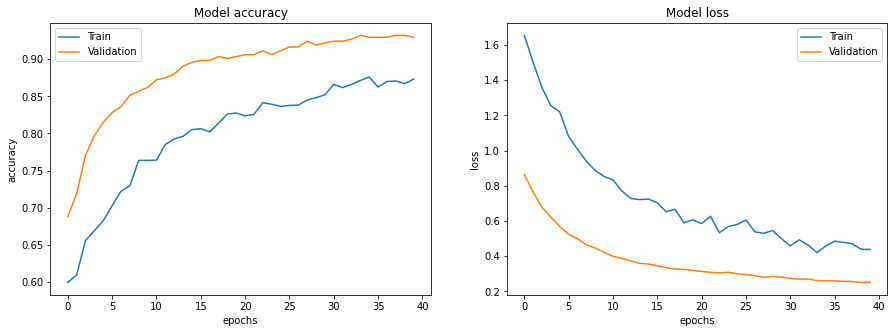

In [ ]:
print_loss_acc(history_3)

Classification Report
              precision    recall  f1-score   support

      Normal       0.87      0.71      0.78       234
   Pneumonia       0.80      0.92      0.85       296

    accuracy                           0.82       530
   macro avg       0.84      0.81      0.82       530
weighted avg       0.83      0.82      0.82       530

Confusion Matrix


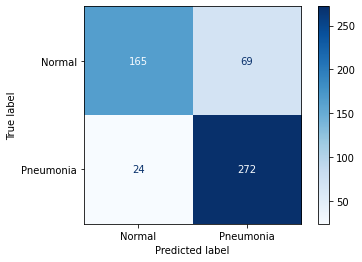

In [ ]:
predictions = model_res.predict_generator(test_generator, NB_TEST_SAMPLES // 32 +1)
predictions = [1 if x>0.5 else 0 for x in predictions]

print_cm_cl_report(test_generator, predictions)

We can see that the model that uses ResNet for feature extraction performs a bit better than the previous model based too on transfer learning. Less FN are produced, while the number of FP remains about the same. However, the CNN with the five layers for feature extraction still performed better and it's the one that produced the best results according to the way we defined that we will evaluate this classification problem. It has not only the highest accuracy but also minimum FN and high recall score.

Overall, we conclude that NN models performed better than ML models. ML models needed extra preprocessing steps to improve feature extraction and therefore their performance. On the contrary, NN models achieved 91% accuracy without implementing any preprocessing steps in input images, except for resize and normalization inside data generators. However, the dataset is not that big it was needed to apply data augmentation.